<a href="https://colab.research.google.com/github/Bcopeland64/Data-Science-Notebooks/blob/master/Copy_of_TS_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© 2021 Zaka AI, Inc. All Rights Reserved

# Time-series Prediction
---
## Case Study: Smart Energy Management in Households

**Outline:**

In this project-based course, you will learn proper practices of working with time-series data for prediction tasks.

---
## Table of Contents 

### Section 1. Exploratory Data Analysis

* 1.1: Data Loading and Understanding 
* 1.2: Data Cleaning 
* 1.3: Data Visualization

### Section 2. Data Preparation 

* 2.1: Preparing Data for Forecasting
* 2.2: Train/Test Splits

### Section 3. Modeling Building

### Section 4. Model Evaluation
--- 

## 0. Scenario, Problem & Dataset Description

Today, you will dive into a dataset collected from a home in Paris, which we would like to use Time-Series to **learn** and **make predictions** of the household owner's energy consumption patterns. The dataset collects 2,075,259 measurements between December 2006 and November 2010 (so we have 47 months of data to work with).

### The data is collected from multiple smart meters and contains the following attributes/features:

- date: Date in format dd/mm/yyyy

- time: time in format hh:mm:ss

- global_active_power: household global minute-averaged active power (in kilowatt)

- global_reactive_power: household global minute-averaged reactive power (in kilowatt)

- voltage: minute-averaged voltage (in volt)

- global_intensity: household global minute-averaged current intensity (in ampere)

- sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

- sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

- sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

### Some notes we have about the dataset are:
1.  (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.   The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows *missing values on April 29, 2007*.

You can find the dataset description [here](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption).

## 1. Exploratory Data Analysis

### Importing Libraries 

First off, let's import the python libraries we know we'll typically be using.

Some of the common ones are:

*   [numpy](https://www.numpy.org/) - supports large, multidimensional arrays and has a lot of useful mathematical built-in functions to run on these arrays
*   [pandas](https://pandas.pydata.org/) - offers high-performance, easy-to-use data structures (e.g. can store data of multiple types in one data structure)
*   [matplotlib](https://matplotlib.org/) - 2D plotting library

In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Data Loading 

You can download the dataset [here](https://drive.google.com/file/d/16-wyJTLif02ZEMB0AU1MSbL9LieFZI5l/view).


In [2]:
!git clone https://github.com/zaka-ai/time-series-course.git

%cd time-series-course

Cloning into 'time-series-course'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 47 (delta 2), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (47/47), done.
Checking out files: 100% (30/30), done.
/content/time-series-course


The data is in a ZIP file so we need to unzip first

In [3]:
!unzip household_power_consumption.txt.zip

Archive:  household_power_consumption.txt.zip
  inflating: household_power_consumption.txt  
   creating: __MACOSX/
  inflating: __MACOSX/._household_power_consumption.txt  


In [4]:
path_to_data = 'household_power_consumption.txt'
data = pd.read_csv(path_to_data, sep=';', low_memory=False) 

# quickly visualize - print first 5 rows
data.head()  

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


#### Some points to pay attention to

*   Our data is collected every minute. 
*   We have measurements collected in different units. 
*   What are our descriptors? What is our target?



To answer the last question above, we need to define our problem. What are we trying to do?

We can choose to frame the problem as one of the following:

1.  We can predict a household's total power consumption. This can be useful for:

> *   Demand planning by power distribution companies
> *   Powering/connecting to renewable energy sources 
> *   Financial planning of users

2.  We can predict the household's consumption of specific power devices. This can be useful for:

> *   Users can better plan their consumption of loads
> *   Smart grids can switch off low-demand devices during peak demand hours (e.g. fridge)

Today, we will be answering a specific question:

***Given recent power consumption, what is the expected total power consumption for the next week?***


#### Data Inspection

In [5]:
# inspect types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [6]:
# let's get a look at summary of statistics
data.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


Only numeric columns are considered in `data.describe()`. To include the object-type column, we use the following command

In [7]:
data.describe(include='all')

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2.049280e+06
unique,1442,1440,4187,533,2838,222,89,82,NaN
top,27/8/2008,20:11:00,?,0.000,?,1.000,0.000,0.000,NaN
freq,1440,1442,25979,481561,25979,172785,1880175,1436830,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.458447e+00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.437154e+00
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700000e+01


In [8]:
# data shape
rows, cols = data.shape
print(f"The dataset is composed of {rows} rows and {cols} columns.")

The dataset is composed of 2075259 rows and 9 columns.


We can clearly see that we have missing data that will give us a lot of problems when preprocessing and visualizing the data.

**HOWEVER** we still can't split the data because we do not have it in the correct format yet. Meaning, what is our X and what is our y in this case? We need to prepare the data!

---

#### Data Cleaning

In the `describe()` summary, we could see a symbol "?" showing in our data. Perhaps this is what the data collectors used to resemble missing values. Let's check April 29 of 2007 that we already know has a missing value.

We can make use of the date and time columns to easily search through our data. We will turn the date and time to indicies to easily navigate!

In [9]:
data = pd.read_csv(path_to_data, sep=';', infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'], low_memory=False) 
data.head()  

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


Now we can easily search our data. 

In [10]:
import datetime 
# search for April 29, 2007 using the datetime index on the dataframe
data.loc[datetime.datetime(year=2007,month=4,day=29)] 

Global_active_power        ?
Global_reactive_power      ?
Voltage                    ?
Global_intensity           ?
Sub_metering_1             ?
Sub_metering_2             ?
Sub_metering_3           NaN
Name: 2007-04-29 00:00:00, dtype: object

**Finding:** "?" is a symbol used to represent missing values! 

Let's take care of these missing values.

In [11]:
# Removing rows with missing values or "?"

# First. let's convert "?"" to nan
data.replace('?', np.nan, inplace=True)

In [12]:
# Let's check April 29, 2007 to see if we have properly replaced "?" with NaN
data.loc[datetime.datetime(year=2007,month=4,day=29)] 

Global_active_power      NaN
Global_reactive_power    NaN
Voltage                  NaN
Global_intensity         NaN
Sub_metering_1           NaN
Sub_metering_2           NaN
Sub_metering_3           NaN
Name: 2007-04-29 00:00:00, dtype: object

In [13]:
# So our data should be all float types, let's check
data.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [14]:
# We need to change the data from string to float
data = data.astype('float32')
data.dtypes

Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Sub_metering_1           float32
Sub_metering_2           float32
Sub_metering_3           float32
dtype: object

In [15]:
# Second. let's check how many missing values we have
data.isnull().sum() 

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [16]:
# One solution we could use is to drop all rows with missing values
data_remove = data.dropna()   
data_remove.shape

(2049280, 7)

In [17]:
InitialNumberOfRows = 2075259
AfterRemoval = 2049280
TotalDroppedRows = InitialNumberOfRows - AfterRemoval
print(TotalDroppedRows)

25979


2,075,259 - 2,049,280 = we dropped 25979 rows! 

In [ ]:
# Let's check April 29, 2007 to see if we have properly removed missing values from the dataset
data_remove.loc[datetime.datetime(year=2007,month=4,day=29)] 

> We were expecting an error! Since when we dropped null values, we dropped April 29 which had a lot of null values. So when we try to locate in the new data_remove set, we would not be able to do so.


In [20]:
data_remove.isnull().any()

Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
Sub_metering_3           False
dtype: bool

In [21]:
# But we don't want to lose this many samples (25K!) so let's replace the missing values with the mean
data = data.fillna(data.mean())

In [22]:
# let's check if we have correctly replaced April 29, 2007 with the mean
data.loc[datetime.datetime(year=2007,month=4,day=29)] 

Global_active_power        1.091631
Global_reactive_power      0.123704
Voltage                  243.381332
Global_intensity           4.629239
Sub_metering_1             1.121923
Sub_metering_2             1.298520
Sub_metering_3             6.458447
Name: 2007-04-29 00:00:00, dtype: float32

In [23]:
# Any missing values left?
data.isnull().any()

Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
Sub_metering_3           False
dtype: bool

**DONE** We have cleaned our data from missing values. 

---

#### Data Preprocessing

Each measurement/sample in a row is collected every minute of the day for 47 months! Do we need all this information?

If we're doing a prediction for the next week level consumptions, then we don't need to know how much power is being consumed per minute (too specific). We could probably get by with the consumption level per hour. We can likely even get by per day.




In [24]:
# we can easily resample minutes to days
daily_data = data.resample('D').sum()

# check new size of data (remember we lumped readings so data will shrink by an order of 1/(60 minutes per hour *24 hours per day)) 
daily_data.shape

(1442, 7)

In [25]:
# let's take a look at how our index looks like now
daily_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


We now have our data sampled per day and in the proper setup for **one week ahead prediction.**

### Data Visualization

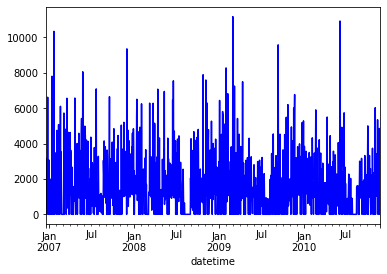

In [27]:
daily_data_meter_1 = daily_data['Sub_metering_1']
daily_data_meter_2 = daily_data['Sub_metering_2']
daily_data_meter_3 = daily_data['Sub_metering_3']

daily_data_meter_1.plot(color="blue"); # can plot directly in pandas

We can see how power consumption looks like for kitchen appliances.

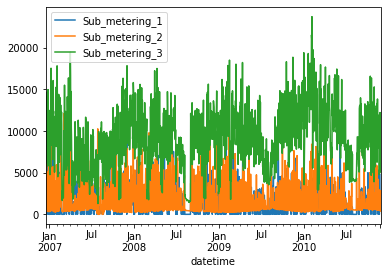

In [28]:
# Can plot them all in one figure directly from pandas
daily_data_per_meter = daily_data[['Sub_metering_1','Sub_metering_2','Sub_metering_3']]
daily_data_per_meter.plot()

It seems like `sub_metering_3` (which refers to heating and air conditioning) seems to have a unique pattern compared to the remaining measurements.

Text(0, 0.5, 'Watt-hour')

<Figure size 432x288 with 0 Axes>

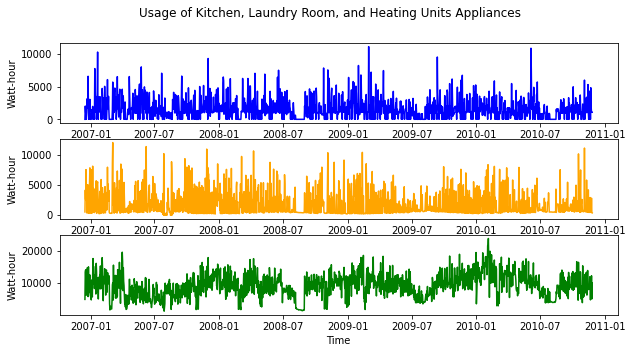

In [29]:
# Using matplotlib
plt.figure()                # the first figure
plt.figure(figsize=(10,5))  # define figure size (rows, cols) in inches
plt.suptitle('Usage of Kitchen, Laundry Room, and Heating Units Appliances')

plt.subplot(311)             # the first subplot in the first figure
plt.plot(daily_data['Sub_metering_1'],color="blue")
plt.xlabel('Time')
plt.ylabel('Watt-hour')

plt.subplot(312)             # the second subplot in the first figure
plt.plot(daily_data['Sub_metering_2'],color="orange")
plt.xlabel('Time')
plt.ylabel('Watt-hour')

plt.subplot(313)             # the third subplot in the first figure
plt.plot(daily_data['Sub_metering_3'],color="green")
plt.xlabel('Time')
plt.ylabel('Watt-hour')


**Question:** Do you notice anything about `sub_metering_3`?

**Finding:** There is a clear cyclic component. This is due to high consumption of heating appliances during winter and low consumption during summers. This behavior would look different if we were collecting measurements from UAE, for example.

### Data Preparation

OK, so now we should split our data into train and test sets. How do we do that? **Which columns are our descriptors and where's our target?**

In [30]:
# The first and last days in the data are:
daily_data.iloc[[0]] # first day

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0


In [31]:
daily_data.iloc[[-1]] # last day

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-26,1488.104004,120.826004,303487.5625,6259.799805,1080.0,385.0,9989.0


Starting date: 2006-12-16
Ending date: 2010-11-26	

If we want one week ahead prediction, it makes sense to use the previous week of data to predict the week ahead. 

To set this up properly, we would want our week to start on Monday and end on Sunday.

> The **first Monday in the dataset** is December 18, 2006 (which is the third row in the dataset).

> The **last Sunday in the dataset** is November 21, 2010. (which is the -6 from the end).

Organizing the data into the step up above, we would have a total of 205 weeks.

*No... didn't count them myself! Here's an online [calculator](https://planetcalc.com/274/?license=1).*

In [32]:
daily_data.iloc[[2]] # First day for us

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-18,2203.825928,161.792007,347373.625,9247.200195,1063.0,2621.0,14018.0


In [33]:
daily_data.iloc[[-6]] # Last day for us 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-21,900.909973,119.624001,347299.46875,3798.600098,0.0,506.0,4778.0


If we decide to divide our data into ~70% training and ~30% testing, then we would need:

30% of 205 weeks = 61 weeks

61 weeks = 427 days

We are starting at day -5 so we need to read up to -(427+5)= -432. **Great!**

In [34]:
data = daily_data.values
train, test = data[2:-432], data[-432:-5] # Important numbers (ignoring the lingering days that don't fit into our Monday-Sunday structure)

# reshape into windows of weekly data (one week = 7 days) (total days / 7 = total weeks)
train = np.array(np.split(train, len(train)/7))
test = np.array(np.split(test, len(test)/7))

# check shape
print(f"The training set is {train.shape} and the test set is {test.shape}.")

The training set is (144, 7, 7) and the test set is (61, 7, 7).


Where do these 3 dimensions come from? **(weeks, days, features)**

So, now we have the training and testing sets. One more thing we need to prepare before moving to modeling is:

**How do we setup the data for supervised learning?** That is, what is my *X* and what is my *y*?

At each instant, we want to feed the model a week, and predict the week ahead. We don't do this prediction for Mondays only; we do them for every day of the week.

Meaning, we want our input (X) and output (y) to look like:

```
[Input], [Output]
[d01, d02, d03, d04, d05, d06, d07], [d08, d09, d10, d11, d12, d13, d14]
[d02, d03, d04, d05, d06, d07, d08], [d09, d10, d11, d12, d13, d14, d15]
Etc ...
```


In [35]:
# flatten the train data over all weeks 
train = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) # shape: [weeks*days, sensors] = [total days, sensors]
# check shape
train.shape

(1008, 7)

In [36]:
# flatten the test data over all weeks 
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2])) # shape: [weeks*days, sensors]
# check shape
test.shape

(427, 7)

In [37]:
def supervised_setup(data, column):
  # data: expects train/test set with 2 dimensions of (samples, days)
  # column: expects integer indicating column number of meter of interest

  X, y = [], [] # start with empty lists for X and y
  input_start = 0 # iterator
  n_input = 7 # we want 7 days as input
  n_out = 7 # we want 7 days as output

  # step over the entire history one time step at a time
  for i in range(len(data)):
	  # define the end of the input and corresponding output
	  input_end = input_start + n_input
	  output_end = input_end + n_out
	
    # ensure we have enough data for this instance
	  if output_end < len(data):
		  x_input = data[input_start:input_end, column]
		  x_input = x_input.reshape((len(x_input), 1))
  
		  X.append(x_input)
		  y.append(data[input_end:output_end, 0])
  
	  # move along one time step
	  input_start += 1
  return np.array(X), np.array(y)

## 3. Model Building

Recall, our dataset has different measures. Let's look at them again.

In [38]:
daily_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


**What is it that we want to predict?**

*   Univariate Forecasting - choose one specific measure that you want to carry out predictions on. Only need one model. 
*   Multivariate Forecasting - carry out predictions on multiple measures. Build a model for each measure OR feed each as a separate channel to the neural network (remember how we treat RGB channels in computer vision).

**First.** We will build a univariate prediction model to predict the next week consumption levels of total active power in the household (that is, column 0). Notice, predict the next week consumption, day by day, is a multi-step ahead prediction where we are predicting SEVEN future values at once. 

If we were doing one day ahead prediction, this would correspond to one-step ahead prediction.



In [39]:
# split the data for "total active power"
X_train, y_train = supervised_setup(train, 0)
X_test, y_test = supervised_setup(test, 0)

In [40]:
# let's check the shape of these subsets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(994, 7, 1) (994, 7)
(413, 7, 1) (413, 7)


#### Let's build our prediction model!

#### **What type of neural network would we use here?**

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

We will run a Long-Short Term Memory (LSTM) network since we are dealing with sequential data *(similar to dealing with language)*.

In [42]:
# let's define some parameters for our LSTM model
n_samples, window_size, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[1]
n_cells, n_neurons = 64, 20

# build the network archiecture
model = Sequential()
model.add(LSTM(n_cells, activation='relu', input_shape=(n_samples, window_size), return_sequences=True)) # set return_sequences=True to add new LSTM layer
model.add(LSTM(n_cells, activation='relu'))
#model.add(LSTM(n_cells))
model.add(Dense(n_neurons, activation='relu'))
model.add(Dense(n_outputs)) #by default the activation fct is 'linear', so we can skip assigning activation = 'linear', which is the same thing 

# compile the model for regression (we are predicting a value number)
# we define the mean squared error as an evaluation metric for training & define ADAM as an optimization algorithm 
model.compile(loss='mse', optimizer='adam')
	
# train the network
model.fit(X_train, y_train, epochs=50, batch_size=16)

Epoch 1/50
63/63 [==============================] - 6s 20ms/step - loss: 2189419.5293
Epoch 2/50
63/63 [==============================] - 1s 20ms/step - loss: 349252.0957
Epoch 3/50
63/63 [==============================] - 1s 20ms/step - loss: 317704.8257
Epoch 4/50
63/63 [==============================] - 1s 20ms/step - loss: 289804.0962
Epoch 5/50
63/63 [==============================] - 1s 20ms/step - loss: 316412.0137
Epoch 6/50
63/63 [==============================] - 1s 21ms/step - loss: 315409.8127
Epoch 7/50
63/63 [==============================] - 1s 20ms/step - loss: 292838.9209
Epoch 8/50
63/63 [==============================] - 1s 21ms/step - loss: 314981.6565
Epoch 9/50
63/63 [==============================] - 1s 21ms/step - loss: 332390.7676
Epoch 10/50
63/63 [==============================] - 1s 20ms/step - loss: 339533.4971
Epoch 11/50
63/63 [==============================] - 1s 20ms/step - loss: 291299.8916
Epoch 12/50
63/63 [==============================] - 1s 21ms/s

## 4. Model Evaluation

In [47]:
# make a prediction
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2])) #reshape data into (days, features)
	
  # retrieve last observations (last 7 days) for input data
	input_x = data[-n_input:, 0]
	
  # reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1)) #(1,7,1) Keras expects first argument to be number of samples
	
  # forecast the next week
	predicted_y = model.predict(input_x, verbose=0)
	
  # we only want the vector forecast
	predicted_y = predicted_y[0]
	return predicted_y


In [48]:
# To start evaluating our model, we can start from the last week in our training data
history = [x for x in X_train] # converting history into a list
n_input = 7

# We do walk-forward (walking in the future) validation for each week
predictions = []
	
for i in range(len(X_test)):
	# predict the week
	y_predicted = forecast(model, history, n_input) 
	# collect predictions
	predictions.append(y_predicted)
	# get real observation and add it to my history 
	history.append(X_test[i,:]) # use actual data to predict in next iteration instead of using y_predicted

In [45]:
from sklearn.metrics import mean_squared_error

# Now, we want to evaluate our model
predictions = np.array(predictions) # converting from list to np.array

# But we want to see how well our model is doing day by day 
scores = []
# calculate an RMSE score for each day
for i in range(y_test.shape[1]): # Loop over the days of each week (shape[1] refers to the days since y_test.shape was (308,7) )
  # calculate mse for each day
  mse = mean_squared_error(y_test[:, i], predictions[:, i])
  rmse = np.sqrt(mse)
	# store
  scores.append(rmse)
 
# calculate overall RMSE for the week
weekly_score = np.array(scores).mean()

[AVG] ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']: 
 [412.846] [394.27884, 394.9954, 411.83215, 406.5931, 419.38867, 442.83282, 420.00037]


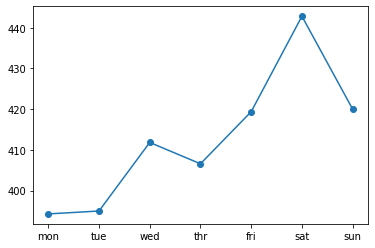

In [46]:
# print and plot scores
days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
print('[AVG] %s: \n [%.3f] %s' % (days, weekly_score, scores))

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

As we progress in the future, the error is increasing. The model scores higher errors due to getting further and further from the real values.

**Acknowledgments**

The dataset was downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#).